# Métodos Wrapper y Embedded

En este notebook se revisarán los conceptos de:

1. Métodos *wrapper*
2. Métodos *embedded*

Primero cargamos librerías y funciones necesarias


In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

import warnings
warnings.filterwarnings('ignore')

# 1. Métodos Wrapper

Estos métodos utilizan un algoritmo de machine learning como caja negra para rankear distintos subconjuntos de variables de acuerdo a su capacidad predictiva. Normalmente se usan mediante procedimientos hacia delante/detrás en combinación con validación cruzada.

### *The wrong and right way to do cross-validation*

Este ejemplo ha sido inspirado en *7.10.2 The Wrong and Right Way to Do Cross-validation* del libro
"The Elements of Statistical Learning". Hastie, Tibshirani, Friedman

Error rate (%): 3.5719999999999974


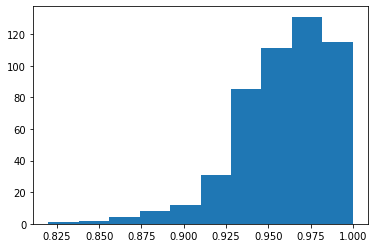

In [2]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.feature_selection import f_classif


# This is the WRONG way

np.random.seed(0)
score = []

for i in range(500): # This is run for a number of experiments. Montecarlo simulation
    
    # Create toy example
    N = 50
    y = np.concatenate([-1*np.ones(int(N/2)),np.ones(int(N/2))]) # target
    X = np.random.randn(N, 5000)                       # predictors are random variables!!
    
    # Note here, the ranking and selection is performed outside the CV loop
    f_test, _ = f_classif(X, y)
    f_test /= np.max(f_test)
    
    
    ranking = np.argsort(f_test)[::-1] 
    selected = ranking[0:50]
    Xs = X[:,selected]
    
    # 1-neighbor classifier
    knn = KNeighborsClassifier(n_neighbors=1)
    
    # 5-fold CV
    kf  = KFold(n_splits=5, shuffle = True)
    score_i = []
    
    for train, validation in kf.split(Xs):
        knn.fit(Xs[train,:],y[train])
        accuracy = knn.score(Xs[validation,:],y[validation])
        score_i.append(accuracy) 
    
    score.append(np.mean(score_i))

print("Error rate (%): " + str((1-np.mean(score))*100))

plt.hist(score)
plt.show()

Error rate (%): 52.664


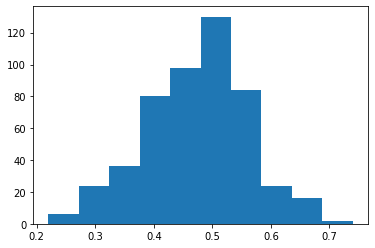

In [3]:
# This is the RIGHT way

np.random.seed(0)
score = []

for i in range(500): # This runs for a number of experiments. Montecarlo simulation
    
    # Create toy example
    N = 50
    y = np.concatenate([-1*np.ones(int(N/2)),np.ones(int(N/2))]) # target
    X = np.random.randn(N, 5000)                       # predictors, again random variables
    
    # 1-neighbor classifier
    knn = KNeighborsClassifier(n_neighbors=1)
    
    # 5-fold CV
    kf  = KFold(n_splits=5, shuffle = True)
    score_i = []
    
    for train, validation in kf.split(X):
        
        # Note here, the ranking and selection is performed inside the CV loop
        f_test, _ = f_classif(X[train,:], y[train])
        f_test /= np.max(f_test)
        ranking = np.argsort(f_test)[::-1] 
        selected = ranking[0:50]
        
        Xs = X[:,selected]
        
        knn.fit(Xs[train,:],y[train])
        accuracy = knn.score(Xs[validation,:],y[validation])
        
        score_i.append(accuracy) 
    
    score.append(np.mean(score_i))

print("Error rate (%): " + str((1-np.mean(score))*100))

plt.hist(score)
plt.show()

# 2. Métodos embedded

Vamos a trabajar directamente sobre la base de datos  de viviendas [House Sales in King COunty, USA](https://www.kaggle.com/harlfoxem/housesalesprediction), así que lo primero es cargar los datos

In [16]:
# cargamos datos
house_data = pd.read_csv("./data/kc_house_data.csv") # cargamos fichero

# Eliminamos las columnas id y date 
house_data = house_data.drop(['id','date'], axis=1)

# convertir las variables en pies al cuadrado en metros al cuadrado 
feetFeatures = ['sqft_living','sqft_lot','sqft_above','sqft_basement','sqft_living15','sqft_lot15']
house_data[feetFeatures] = house_data[feetFeatures].apply(lambda x: x * 0.3048 * 0.3048)

# renombramos
house_data.columns = ['price','bedrooms','bathrooms','sqm_living','sqm_lot','floors','waterfront','view','condition',
                      'grade','sqm_above','sqm_basement','yr_built','yr_renovated','zip_code','lat','long',
                      'sqm_living15','sqm_lot15']

# añadimos las nuevas variables
house_data['years']            = 2015 - house_data['yr_built']
#house_data['bedrooms_squared'] = house_data['bedrooms'].apply(lambda x: x**2)
house_data['bed_bath_rooms']   = house_data['bedrooms']*house_data['bathrooms']
house_data['log_sqm_living']   = house_data['sqm_living'].apply(lambda x: np.log(x))
#house_data['lat_plus_long']    = house_data['lat']*house_data['long']

house_data.head()

,price,bedrooms,bathrooms,sqm_living,sqm_lot,floors,waterfront,view,condition,grade,...,yr_built,yr_renovated,zip_code,lat,long,sqm_living15,sqm_lot15,years,bed_bath_rooms,log_sqm_living
0,221900.0,3,1.00,109.625587,524.902176,1.0,0,0,3,7,...,1955,0,98178,47.5112,-122.257,124.490074,524.902176,60,3.00,4.697071
1,538000.0,3,2.25,238.760813,672.803816,2.0,0,0,3,7,...,1951,1991,98125,47.7210,-122.319,157.006138,709.686323,64,6.75,5.475462
2,180000.0,2,1.00,71.535341,929.030400,1.0,0,0,3,6,...,1933,0,98028,47.7379,-122.233,252.696269,748.984308,82,2.00,4.270192
3,604000.0,4,3.00,182.089958,464.515200,1.0,0,0,5,7,...,1965,0,98136,47.5208,-122.393,126.348134,464.515200,50,12.00,5.204501
4,510000.0,3,2.00,156.077107,750.656563,1.0,0,0,3,8,...,1987,0,98074,47.6168,-122.045,167.225472,697.051509,28,6.00,5.050350


In [5]:
# convertimos el DataFrame al formato necesario para scikit-learn
data = house_data.values

y = data[:,0:1]     # nos quedamos con la 1ª columna, price
X = data[:,1:]      # nos quedamos con el resto

feature_names = house_data.columns[1:]

In [6]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

# Dividimos los datos en entrenamiento y test (75 training, 25 test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state = 2)

print('Datos entrenamiento: ', X_train.shape)
print('Datos test: ', X_test.shape)

# Escalamos (con los datos de train)
scaler = preprocessing.StandardScaler().fit(X_train)
XtrainScaled = scaler.transform(X_train)
XtestScaled = scaler.transform(X_test)

# MAL
#scaler = preprocessing.StandardScaler().fit(X) <---- MAL
#XtrainScaled = scaler.transform(X_train)
#XtestScaled = scaler.transform(X_test)

Datos entrenamiento:  (16209, 21)
Datos test:  (5404, 21)


En este caso, utilizamos la capacidad de Lasso para seleccionar variable

best mean cross-validation score: -36352938588.655
best parameters: {'alpha': 183.29807108324357}


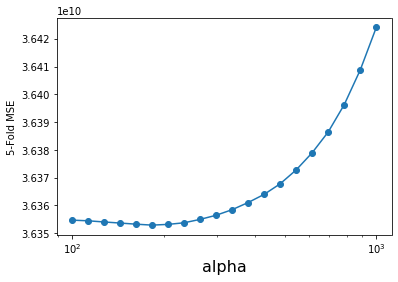

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

alpha_vector = np.logspace(2,3,20)
param_grid = {'alpha': alpha_vector }
grid = GridSearchCV(Lasso(), scoring= 'neg_mean_squared_error', param_grid=param_grid, cv = 10)
grid.fit(XtrainScaled, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

#-1 porque es negado
scores = -1*np.array(grid.cv_results_['mean_test_score'])
plt.semilogx(alpha_vector,scores,'-o')
plt.xlabel('alpha',fontsize=16)
plt.ylabel('5-Fold MSE')
plt.show()

In [11]:
from sklearn.metrics import mean_squared_error

alpha_optimo = grid.best_params_['alpha']
lasso = Lasso(alpha = alpha_optimo).fit(XtrainScaled,y_train)

ytrainLasso = lasso.predict(XtrainScaled)
ytestLasso  = lasso.predict(XtestScaled)
mseTrainModelLasso = mean_squared_error(y_train,ytrainLasso)
mseTestModelLasso = mean_squared_error(y_test,ytestLasso)

print('MSE Modelo Lasso (train): %0.3g' % mseTrainModelLasso)
print('MSE Modelo Lasso (test) : %0.3g' % mseTestModelLasso)

print('RMSE Modelo Lasso (train): %0.3g' % np.sqrt(mseTrainModelLasso))
print('RMSE Modelo Lasso (test) : %0.3g' % np.sqrt(mseTestModelLasso))

w = lasso.coef_
for f,wi in zip(feature_names,w):
    print(f,wi)


MSE Modelo Lasso (train): 3.63e+10
MSE Modelo Lasso (test) : 4e+10
RMSE Modelo Lasso (train): 1.9e+05
RMSE Modelo Lasso (test) : 2e+05
bedrooms -9013.131286923437
bathrooms 33470.81781459413
sqm_living 289441.9508545506
sqm_lot 0.0
floors 9590.53508046727
waterfront 44614.45425466014
view 36168.609665398224
condition 20598.932189327043
grade 118118.0407755248
sqm_above 2095.2364350802513
sqm_basement 0.0
yr_built -62602.50340573169
yr_renovated 10451.81305015114
zip_code -27168.218674468488
lat 80957.71435014314
long -22996.913334158635
sqm_living15 21365.79303459731
sqm_lot15 -5032.175503253093
years 3711.63530021846
bed_bath_rooms 0.0
log_sqm_living -173113.65044249422


In [12]:
house_data['price'].describe()

count    2.161300e+04
mean     5.400881e+05
std      3.671272e+05
min      7.500000e+04
25%      3.219500e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

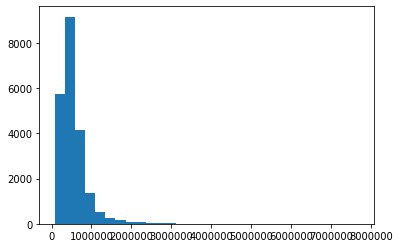

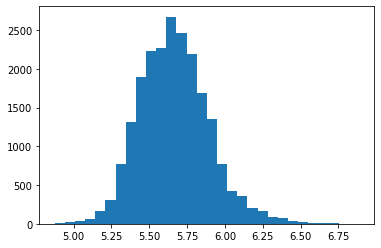

In [15]:
plt.hist(house_data['price'], bins=30)
plt.show()

plt.hist(np.log10(house_data['price']), bins=30)
plt.show()

Como puede apreciarse, con este algoritmo hemos conseguido "desactivar" algunas variables (*sqm_lot*, *sqm_basement*, *long*, *bedrooms_squared*, *bed_bath_rooms*), lo que mejora la interpretabilidad del modelo a costa de aumentar ligeramente el error en test con respecto al método Ridge.

No obstante, siguen apareciendo algunas incoherencias con respecto al valor de los coeficientes, como por ejemplo el asociado a la variable *bedrooms* que tiene valor negativo. 

Si aumentamos el parámetro de regularización y observamos los resultados obtenidos hemos aumentado el error, pero a cambio:

1. Tenemos un modelo más sencillo (menos variables al haber muchos coeficientes nulos) y por tanto, menos susceptible a sufrir overfitting
2. Mejoramos la interpretabilidad del modelo, las variables supervivientes (con coeficiente distintos de cero) parecen concordar con nuestra intuición sobre problema a resolver

Y una vez llegados a este punto, ¿qué podemos hacer? El error de entrenamiento/validación y test es similar, pero todavía es muy alto, así que: 

1. Se podrían definir nuevas variables que nos ayuden a mejorar el error de predicción (mse)
2. Jugar con el parámetro de regularización, para mantener el compromiso entre sencillez/interpretabilidad del modelo y error de predicción (MSE).



In [17]:
# convertimos el DataFrame al formato necesario para scikit-learn
data = house_data.values

y = np.log10(data[:,0:1])     # nos quedamos con la 1ª columna, price
X = data[:,1:]      # nos quedamos con el resto

feature_names = house_data.columns[1:]

In [18]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

# Dividimos los datos en entrenamiento y test (75 training, 25 test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state = 2)

print('Datos entrenamiento: ', X_train.shape)
print('Datos test: ', X_test.shape)

# Escalamos (con los datos de train)
scaler = preprocessing.StandardScaler().fit(X_train)
XtrainScaled = scaler.transform(X_train)
XtestScaled = scaler.transform(X_test)

Datos entrenamiento:  (16209, 21)
Datos test:  (5404, 21)


best mean cross-validation score: -0.012
best parameters: {'alpha': 1e-10}


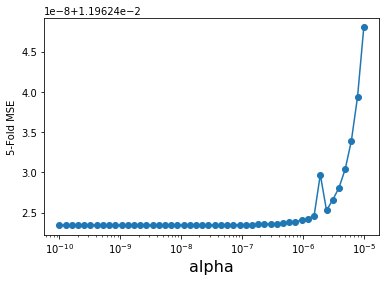

In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

alpha_vector = np.logspace(-10, -5, 50)
param_grid = {'alpha': alpha_vector }
grid = GridSearchCV(Lasso(), scoring= 'neg_mean_squared_error', param_grid=param_grid, cv = 10)
grid.fit(XtrainScaled, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

#-1 porque es negado
scores = -1*np.array(grid.cv_results_['mean_test_score'])
plt.semilogx(alpha_vector,scores,'-o')
plt.xlabel('alpha',fontsize=16)
plt.ylabel('5-Fold MSE')
plt.show()

In [24]:
from sklearn.metrics import mean_squared_error

alpha_optimo = grid.best_params_['alpha']*10
lasso = Lasso(alpha = alpha_optimo).fit(XtrainScaled,y_train)

ytrainLasso = lasso.predict(XtrainScaled)
ytestLasso  = lasso.predict(XtestScaled)
mseTrainModelLasso = mean_squared_error(y_train,ytrainLasso)
mseTestModelLasso = mean_squared_error(y_test,ytestLasso)

print('MSE Modelo Lasso (train): %0.3g' % mseTrainModelLasso)
print('MSE Modelo Lasso (test) : %0.3g' % mseTestModelLasso)

print('RMSE Modelo Lasso (train): %0.3g' % np.sqrt(mseTrainModelLasso))
print('RMSE Modelo Lasso (test) : %0.3g' % np.sqrt(mseTestModelLasso))

w = lasso.coef_
for f,wi in zip(feature_names,w):
    print(f,wi)


MSE Modelo Lasso (train): 0.0119
MSE Modelo Lasso (test) : 0.0118
RMSE Modelo Lasso (train): 0.109
RMSE Modelo Lasso (test) : 0.108
bedrooms -0.012777061643643523
bathrooms 0.015575519088329486
sqm_living 0.09404473833967521
sqm_lot 0.007903449615439371
floors 0.016543150179570986
waterfront 0.014306178490266956
view 0.019556108569565068
condition 0.01754607019320539
grade 0.08001187548151063
sqm_above -0.06581292226563115
sqm_basement -0.0339494812164784
yr_built -0.047892192878442395
yr_renovated 0.006196316859663962
zip_code -0.01501694139305237
lat 0.08442835720480704
long -0.011376860144720433
sqm_living15 0.02838371711832335
sqm_lot15 -0.0028576951488021147
years -0.004005457174115112
bed_bath_rooms 0.008785630915752043
log_sqm_living 0.041314922140888485
